In [1]:
import numpy as np
import os
import pandas as pd
import tools
from tqdm import tqdm
from matplotlib import pyplot as plt
import measures as ms
import seaborn as sns

import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from tempfile import TemporaryDirectory
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
# install Rtrack
rtrack = importr('Rtrack')
rstatix = importr('rstatix')

%load_ext autoreload
%autoreload 2

Warning message:
D-Bus service not found!

- If you are in a container environment, please consider adding the
  following to your configuration to silence this warning:

  options(bspm.sudo = TRUE)

- If you are in a desktop/server environment, please remove any 'bspm'
  installation from the user library and force a new system
  installation as follows:

  $ sudo Rscript --vanilla -e 'install.packages("bspm", repos="https://cran.r-project.org")' 


## Params

In [2]:
path_exp = "/home/jovyan/data/PNN.A-CMWMRawData/"
path_probe_trials = "PNN.A-C.MWM.probe/"
fname_genotypes = "MWMGenotypes.xlsx"

#radius platform in cm
r_platform = 6

# correct the estimated radius of the maze by a small percentage
r_maze_corr = 1.03

## Load metadata

In [3]:
# metadata of each recording
df_info = tools.load_finfo_probe(path_exp+path_probe_trials, extract_platform_quadrants=True)

# genotype data for each individual
def handle_values(val):
    if isinstance(val, str) and '*' in val:
        return val.replace('*', '')  # Replace '*' with an empty string
    return val
df_genotypes = pd.read_excel(path_exp+fname_genotypes, converters={'Subj': handle_values}, usecols=[0, 1, 2])
df_genotypes.set_index('Subj', inplace=True)

# merge both
df_info = pd.merge(df_info, df_genotypes[['sex', 'Geno']], left_on='animal_id', right_index=True, how='left')

## Estimate box boundaries based on trajectory (preferred for now)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


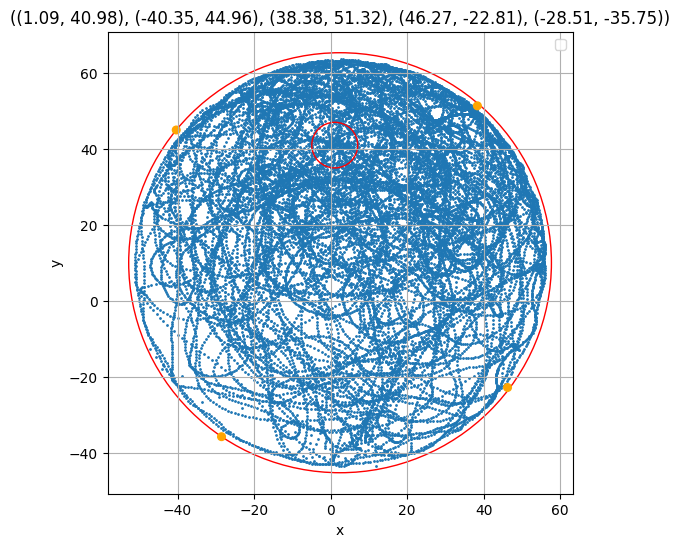

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


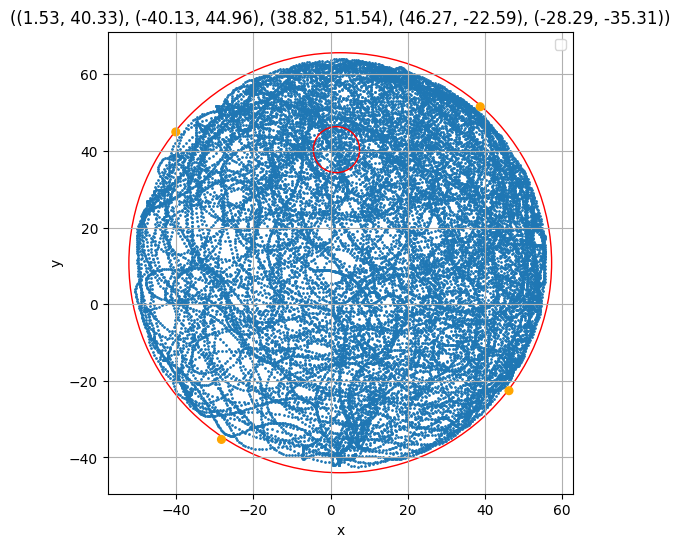

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


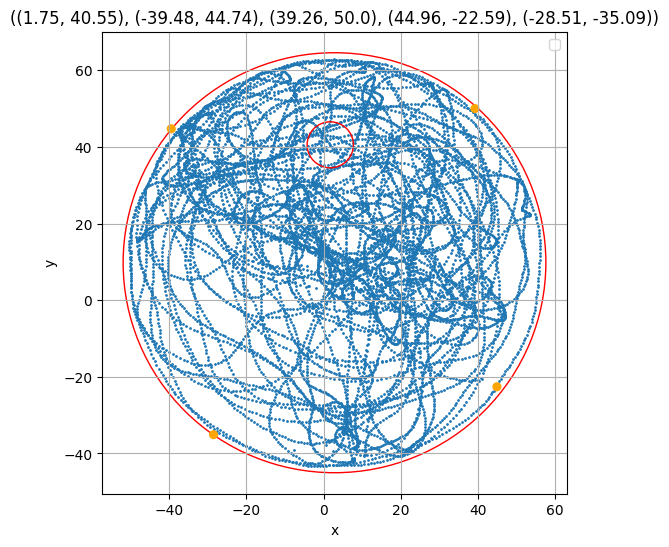

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


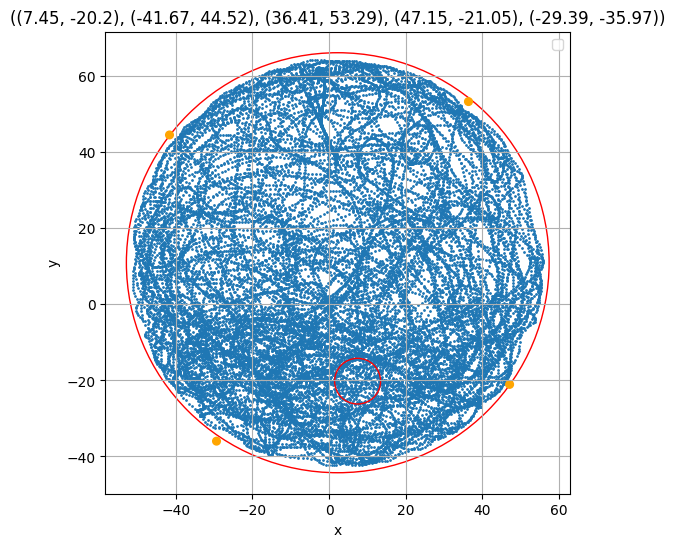

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


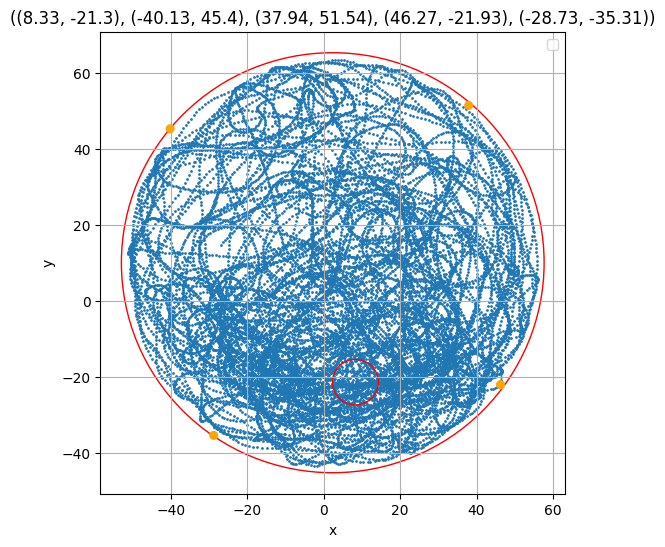

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


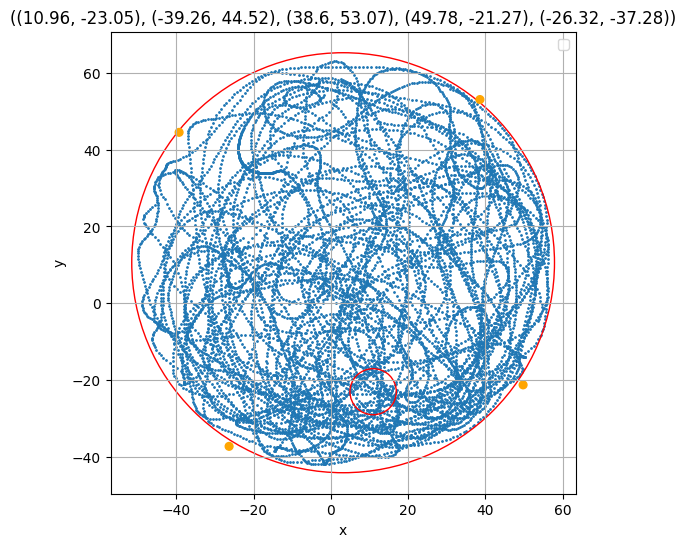

In [4]:
# points to plot
ls_pts = ['platform_pos', 'Q1', 'Q2', 'Q3', 'Q4',]

gp_pts = df_info.groupby(ls_pts)
for i, gp_i in gp_pts:  
    ls_xy = []
    for j, row_j in gp_i.iterrows():
        # load recording
        path_j = row_j['relative_path']
        rec = tools.load_recording(path_j)
        # extract positions
        xy = np.hstack([np.array(rec['X center']), np.array(rec['Y center'])])
        ls_xy.append(xy)
    xy_all = np.vstack(ls_xy)

    # estimate center and radius based on max/min in x and y.
    center_x, center_y, radius = tools.detect_circle_boundaries(xy_all[:, 0], xy_all[:, 1])

    # apply correction factor
    radius = radius * r_maze_corr
    
    # store in dataframe
    df_info.loc[gp_i.index, 'center_x'] = center_x
    df_info.loc[gp_i.index, 'center_y'] = center_y
    df_info.loc[gp_i.index, 'radius'] = radius

    # Create a scatter plot
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.scatter(xy_all[:, 0], xy_all[:, 1], s=1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(i)

    # plot cirlce
    circle_wall = plt.Circle((center_x, center_y), radius, color='red', fill=False)
    ax.add_patch(circle_wall)

    # plot platform
    circle_pltfrm = plt.Circle(i[0], r_platform, color='red', fill=False)
    ax.add_patch(circle_pltfrm)

    # plot quadrant points
    for j in range(1,5):
        circle_pltfrm = plt.Circle(i[j], 1, color='orange', fill=True)
        ax.add_patch(circle_pltfrm)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(i)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
    plt.show()


## Estimate box boundaries based on estimating intersection for between quadrant coordinates (not used)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


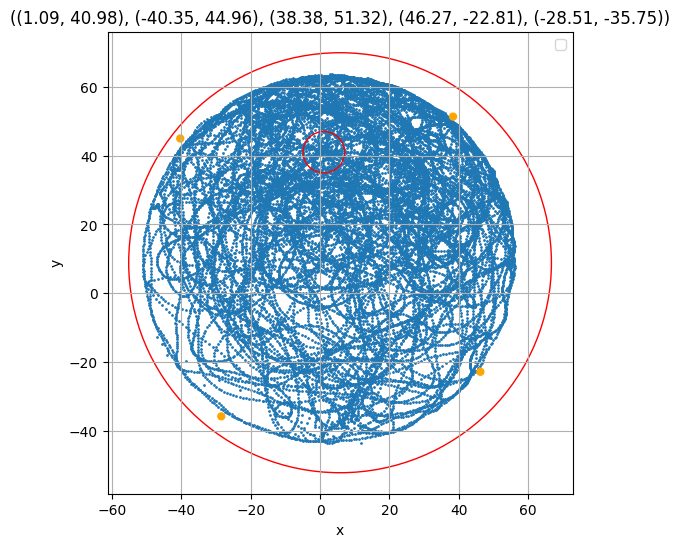

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


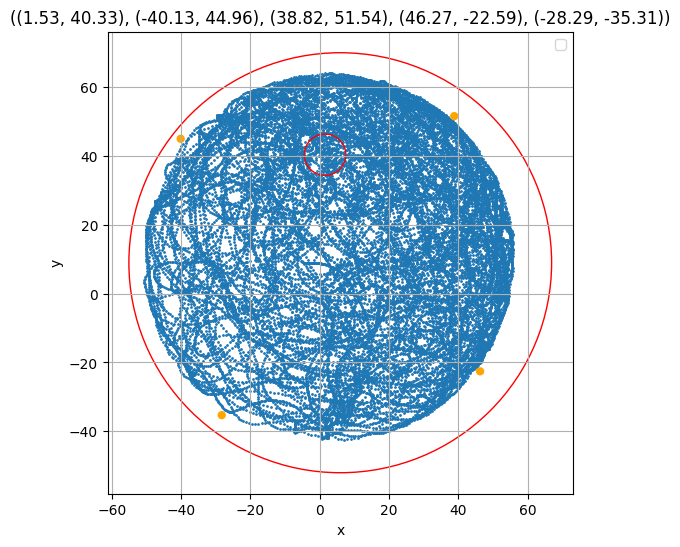

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


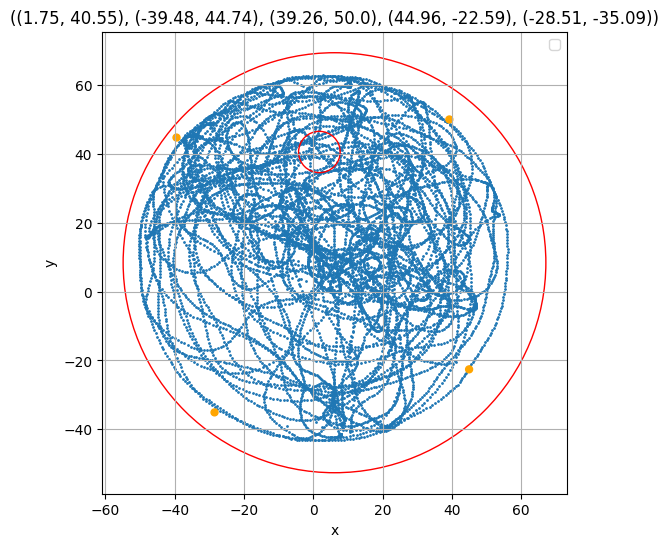

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


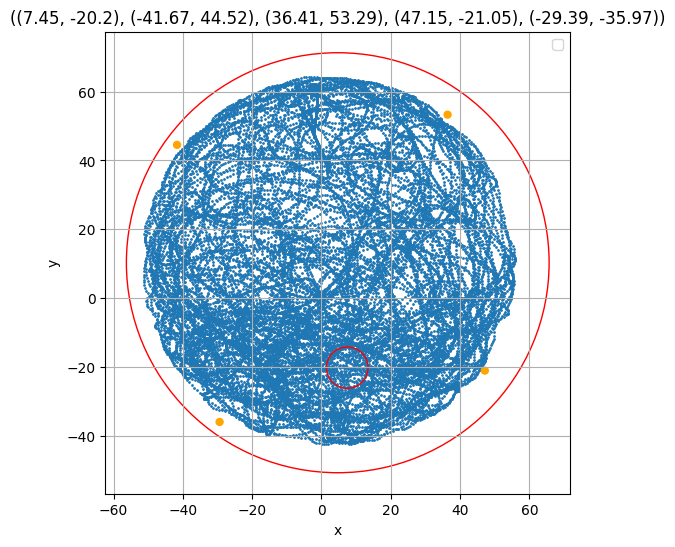

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


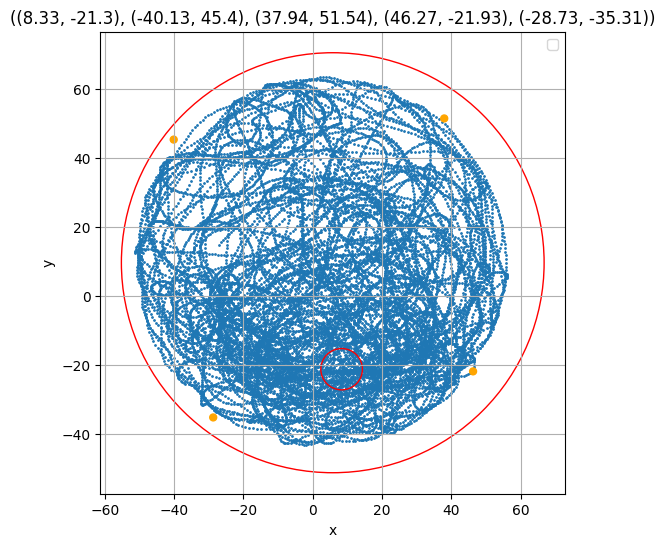

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


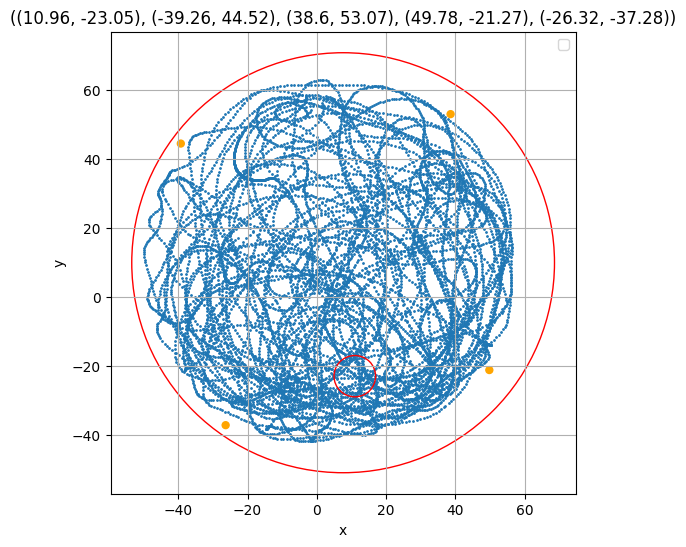

In [5]:
# points to plot
ls_pts = ['platform_pos', 'Q1', 'Q2', 'Q3', 'Q4',]

gp_pts = df_info.groupby(ls_pts)
for i, gp_i in gp_pts:  
    ls_xy = []
    for j, row_j in gp_i.iterrows():
        # load recording
        path_j = row_j['relative_path']
        rec = tools.load_recording(path_j)
        # extract positions
        xy = np.hstack([np.array(rec['X center']), np.array(rec['Y center'])])
        ls_xy.append(xy)
    xy_all = np.vstack(ls_xy)

    # estimate center based on intersection of quadrant points
    center_x, center_y = tools.detect_center_based_on_quadrant_coordinates(
        row_j['Q1'],
        row_j['Q2'],
        row_j['Q3'],
        row_j['Q4'],
    )
    radius = 61  # based on info from experimentalist
#    # estimate center and radius based on max/min in x and y.
#    center_x, center_y, radius = tools.detect_circle_boundaries(xy_all[:, 0], xy_all[:, 1])
    
    # store in dataframe
    #df_info.loc[gp_i.index, 'center_x'] = center_x
    #df_info.loc[gp_i.index, 'center_y'] = center_y
    #df_info.loc[gp_i.index, 'radius'] = radius

    # Create a scatter plot
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.scatter(xy_all[:, 0], xy_all[:, 1], s=1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(i)

    # plot cirlce
    circle_wall = plt.Circle((center_x, center_y), radius, color='red', fill=False)
    ax.add_patch(circle_wall)

    # plot platform
    circle_pltfrm = plt.Circle(i[0], r_platform, color='red', fill=False)
    ax.add_patch(circle_pltfrm)

    # plot quadrant points
    for j in range(1,5):
        circle_pltfrm = plt.Circle(i[j], 1, color='orange', fill=True)
        ax.add_patch(circle_pltfrm)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(i)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
    plt.show()


## Compute measures

In [6]:
ls_res = []

for i, row_i in tqdm(df_info.iterrows()):
    # load recording
    path_i = row_i['relative_path']
    rec = tools.load_recording(path_i)
    # extract positions
    xy = np.hstack([np.array(rec['X center']), np.array(rec['Y center'])])
    # extract trial time
    t_trial = np.array(rec['Trial time']).flatten()
    # get recording time
    t_rec = np.array(rec['Recording time']).flatten()

    
    # compute measures
    # ----------------------
    res = {}
    
    # trial duration
    res['trial duration'] = np.max(t_trial)
    
    # path length
    res['path length'] = ms.path_length(xy)
    
    # mean distance to platform          
    res['mean distance to center of platform'
       ] = ms.mean_distance_to_point(xy, t_rec, row_i['platform_pos'])

    ls_res.append(res)
df_res = pd.DataFrame(ls_res)

df_info = df_info.join(df_res)

83it [00:28,  2.96it/s]


## Plot measures

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


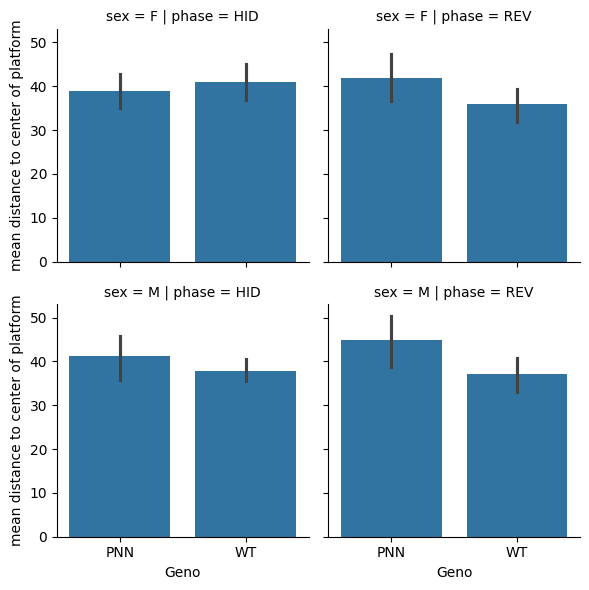

In [7]:
# Create a FacetGrid with 'phase' as the column variable and 'sex' as the row variable
g = sns.FacetGrid(data=df_info, col="phase", row="sex")

# Map a bar plot of trial duration to each grid item
g.map(sns.barplot, "Geno", "mean distance to center of platform")

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


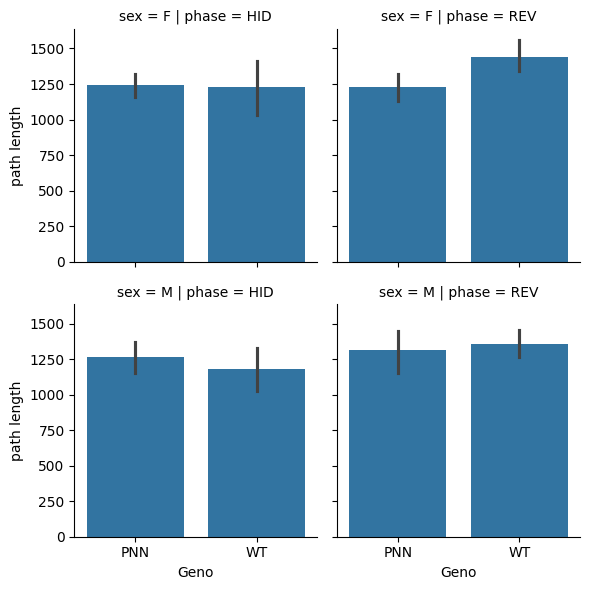

In [8]:
# Create a FacetGrid with 'phase' as the column variable and 'sex' as the row variable
g = sns.FacetGrid(data=df_info, col="phase", row="sex")

# Map a bar plot of trial duration to each grid item
g.map(sns.barplot, "Geno", "path length")

## Occupancy map

In [9]:
ls_occ_map = []

for i, row_i in tqdm(df_info.iterrows()):
    path_i = row_i['relative_path']
    recording_i = tools.load_recording(path_i)
    xy = np.hstack([np.array(recording_i['X center']), np.array(recording_i['Y center'])])

83it [00:27,  2.98it/s]


## Strategy

In [10]:
fname_res = 'data/strategy/df_res.pckl'
compute=True


In [11]:
if compute:
    ls_res = []
    for i, row_i in tqdm(df_info.iterrows()):
        # load recording
        path_i = row_i['relative_path']
        rec = tools.load_recording(path_i)
        # extract positions
        xy = np.hstack([np.array(rec['X center']), np.array(rec['Y center'])])
        # extract trial time
        t_trial = np.array(rec['Trial time']).flatten()
        # get recording time
        t_rec = np.array(rec['Recording time']).flatten()

        # center coordinates
        xy_center = np.array([
            row_i['center_x'],
            row_i['center_y']])
        xy -= xy_center

        ## exclude nan values
        #xy, t = tls.exclude_nan_values(xy, t)

        ## interpolate xy values
        #xy, t = tls.interpolate_xy_values(xy, t, dt)

        # get current platform location
        xy_pltfrm = np.array(row_i['platform_pos'])

        # transform arena and path info for rtrack
        # arena
        s_arena = (
            'time.units = s\n' +
            'type = mwm\n' +
            'trial.length = 60\n'+
            'arena.bounds = circle 0.0 0.0 ' + str(row_i['radius'])+'\n'+
            'goal = circle '+str(xy_pltfrm[0]) + ' ' + str(xy_pltfrm[1]) + ' ' + str(r_platform) + '\n')
        #if np.any(xy_pltfrm_old):
        #    s_arena += 'old.goal = circle '+str(xy_pltfrm_old[0]) + ' ' + str(xy_pltfrm_old[1]) + ' ' + str(d_pltfrm/2.)

        # path
        df_tmp = pd.DataFrame({
            'Time': t_rec,
            'X': xy[:, 0],
            'Y': xy[:, 1]})

        # create temporary directory 
        with TemporaryDirectory() as temp_dir:
            #temp_dir = mkdtemp()
            # store and read arena
            fname_arena = temp_dir+'/arena.txt'
            with open(fname_arena, 'w') as f:
                f.write(s_arena)

            # read arena
            arena = rtrack.read_arena(fname_arena)

            # store path
            fname_path = temp_dir+'/path.csv'
            df_tmp.to_csv(
                fname_path,
                sep=',',
                #header=False,
                index=False)


            dct_args = {'track.format': 'raw.csv'}
            # load path
            path = rtrack.read_path(
                fname_path,
                arena,
                **dct_args)

            metrics = rtrack.calculate_metrics(path, arena)

        # define strategy
        strategy = rtrack.call_strategy(metrics)

        # convert to pandas dataframe
        dct_strat = {x: v for x, v in strategy.items()}
        with localconverter(ro.default_converter + pandas2ri.converter):
            df_strat = ro.conversion.rpy2py(dct_strat['calls'])
        assert len(df_strat) == 1

        res = {
            'strategy_idx': int(df_strat['strategy'].iloc[0]),
            'strategy_name': df_strat['name'].iloc[0],
            'strategy_confidence': df_strat['confidence'].iloc[0]}
        # get also confidences for all other strategies
        for i in range(1, 10):
            res[str(i) + '_conf'] = df_strat[str(i)].iloc[0]
        ls_res.append(res)

    df_res = pd.DataFrame(ls_res)
    df_res.to_pickle(fname_res)

else:
    df_res = pd.read_pickle(fname_res)
df_info = df_info.join(df_res)

83it [00:39,  2.11it/s]


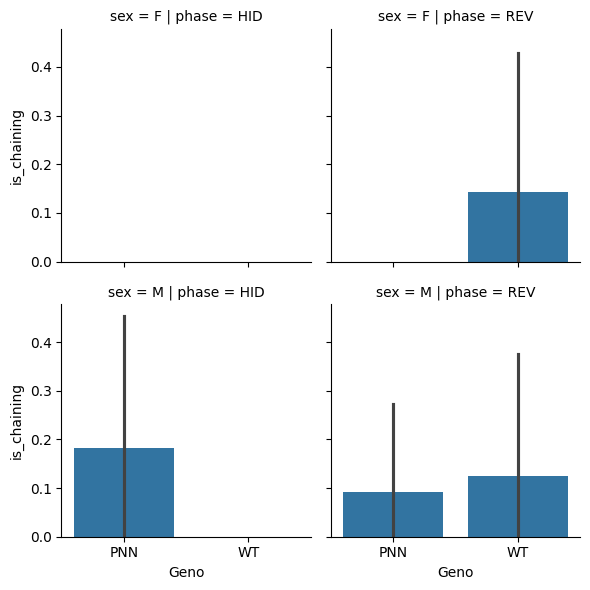

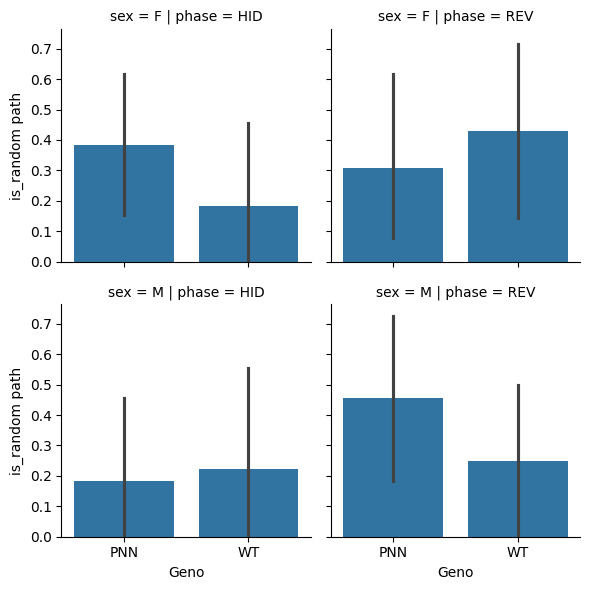

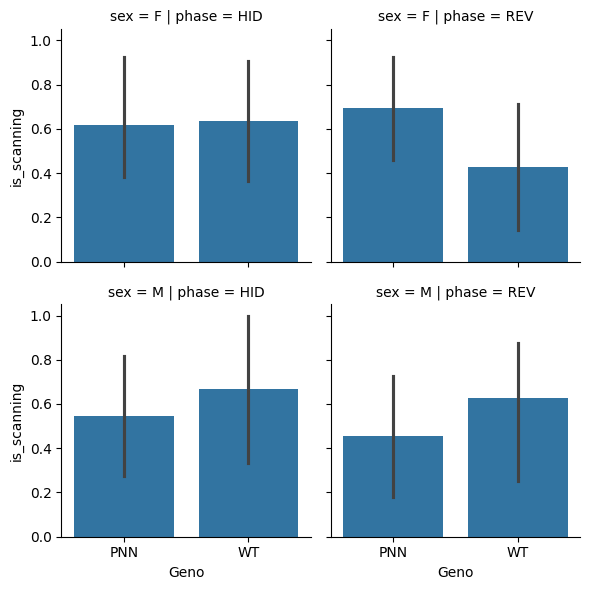

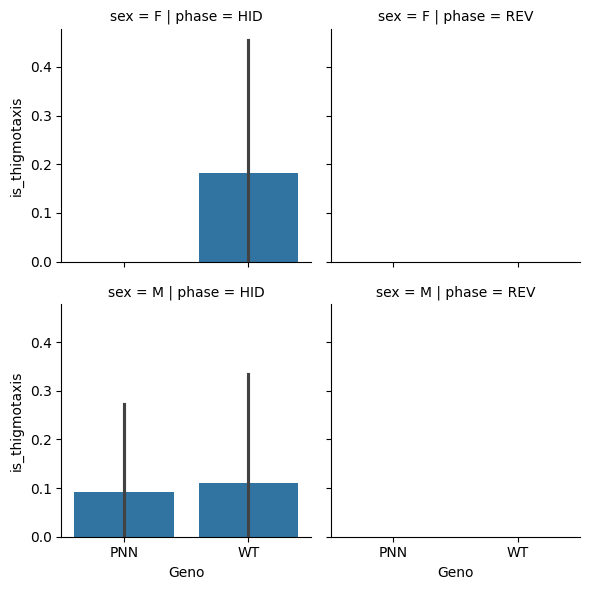

In [12]:
for strat_i in np.unique(df_info['strategy_name']):
    df_info['is_'+strat_i] = df_info['strategy_name']==strat_i

for strat_i in np.unique(df_info['strategy_name']):
    
    # Create a FacetGrid with 'phase' as the column variable and 'sex' as the row variable
    g = sns.FacetGrid(data=df_info, col="phase", row="sex")
    
    # Map a bar plot of trial duration to each grid item
    g.map(sns.barplot, "Geno", 'is_'+strat_i, order=['PNN', 'WT'])

In [13]:
df_info.iloc[0]

fname                                                             PNN.C13.HID.PROBE.xlsx
relative_path                          /home/jovyan/data/PNN.A-CMWMRawData/PNN.A-C.MW...
experiment                                                                           PNN
animal_id                                                                            C13
phase                                                                                HID
platform_name                                                                 Platform 1
platform_pos                                                               (1.53, 40.33)
Q1                                                                       (-40.13, 44.96)
Q2                                                                        (38.82, 51.54)
Q3                                                                       (46.27, -22.59)
Q4                                                                      (-28.29, -35.31)
sex                  